# Youtube API
This program is designed to access the YouTube API and pull information on channels, playlists and videos.

## Importing Modules

First the modules that will be used must be imported.

In [1]:
# googleapiclient imported to access the youtube api
import googleapiclient.discovery
import googleapiclient.errors
# pandas imported to create a dataframe with the information pulled.
import pandas as pd
# isodate imported to convert the youtube duration iso into a datetime format.
import isodate
# matplotlib and seaborn imported to create attractive visuals with the data.
import matplotlib.pyplot as plt
import seaborn as sns

## Accessing YouTube API

This code can be found at https://developers.google.com/youtube/v3/docs/channels/list. Youtube API can be accessed using a generated API key, found in the credentials section of Google Cloud. The channel id chosen in this example is from the Sidemen, a channel my wife and I enjoy. Any channel id can be substituted or multiple channel ids created as a list. 

In [2]:
scopes = ["https://www.googleapis.com/auth/youtube.readonly"]
# The youtube api key can be generated in the credentials section of Google Cloud.
api_key = ""
api_service_name = "youtube"
api_version = "v3"
# Enter the channel id chosen, or a list of channel ids.
channel_ids = ["UCDogdKl7t7NHzQ95aEwkdMw"]
youtube = googleapiclient.discovery.build(
    api_service_name, api_version, developerKey=api_key)

## Creating a dataframe of channel details

This function creates a dataframe of the selected channel(s). This dataframe will contain the information included within the for loop below. One of the more important items is the playlistId, this is used in the next function.

In [3]:
def get_channel_data(youtube, channel_ids):
    all_data = []
    
    request=youtube.channels().list(
        part="snippet, contentDetails, statistics",
        id=",".join(channel_ids)
    )
    response = request.execute()
    
    for item in response["items"]:
        data={
            "channelName": item["snippet"]["title"],
            "subscribers": item["statistics"]["subscriberCount"],
            "views": item["statistics"]["viewCount"],
            "totalVideos": item["statistics"]["videoCount"],
            "playlistId": item["contentDetails"]["relatedPlaylists"]["uploads"]
        }
        all_data.append(data)
    
    return pd.DataFrame(all_data)

In [4]:
channel_stats = get_channel_data(youtube, channel_ids)

## Creating a list of videos

This function creates a list of the videos contained within the playlistId returned from the previous function. The while loop contained below allows all videos in the playlist to be returned, otherwise the function would only return the first 50. 

In [5]:
def get_video_ids(youtube, dataframe):
    
    video_ids = []
    for column in dataframe["playlistId"]:
    
        request = youtube.playlistItems().list(
                part="snippet, contentDetails",
                playlistId=column,
                maxResults=50
            )
        while request:

            response = request.execute()

            for item in response["items"]:
                video_ids.append(item["contentDetails"]["videoId"])
            request = youtube.search().list_next(request, response)

    return video_ids

In [6]:
video_ids = get_video_ids(youtube, channel_stats)

## Finding the video details

This function iterates through the list of videos returned from the previous function and pulls the information contained in the for loop. It then turns this information into a dataframe that can be used for more in depth analysis. The try method below will add information to the list as long as it exist and return a None value if the information is missing.

In [7]:
def get_video_details(youtube, video_ids):

    all_video_info = []

    for i in range(0, len(video_ids), 50):

        request = youtube.videos().list(
                part="snippet, contentDetails, statistics",
                id=",".join(video_ids[i:i+50])
            )
        response = request.execute()

        for video in response["items"]:
            stats_to_keep = {"snippet": ["channelTitle", "title", "description", "tags", "publishedAt"],
                             "statistics": ["viewCount", "likeCount", "favoriteCount", "commentCount"],
                             "contentDetails": ["duration", "definition", "caption"]}
            video_info = {}
            video_info["video_id"] = video["id"]

            for k in stats_to_keep:
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)
    return pd.DataFrame(all_video_info)

In [8]:
video_df = get_video_details(youtube, video_ids)

## Data Preprocessing

To observe if the data returned is clean, some preprocessing is used to determine the cleanliness of the data. Some of the videos are missing information on the view count and like count. Also the dtypes function is used to determine the type of data contained within each column. It appears every column is an object data type. This means that some columns used in analysis will have to be changed.

In [9]:
print(video_df.isnull().any())
print(video_df.dtypes)

video_id         False
channelTitle     False
title            False
description      False
tags             False
publishedAt      False
viewCount         True
likeCount         True
favoriteCount    False
commentCount     False
duration         False
definition       False
caption          False
dtype: bool
video_id         object
channelTitle     object
title            object
description      object
tags             object
publishedAt      object
viewCount        object
likeCount        object
favoriteCount    object
commentCount     object
duration         object
definition       object
caption          object
dtype: object


## Cleaning data and creating columns

The numeric columns are converted into numbers instead of objects. This is also where the duration is changed from an iso format into a datetime format. Two new columns are also created to track the day of the week in which the video was uploaded and to count how many tags are on each video.

In [10]:
numeric_cols = ["viewCount", "likeCount", "favoriteCount", "commentCount"]
video_df[numeric_cols] = video_df[numeric_cols].apply(pd.to_numeric, errors="coerce", axis=1)
video_df["dayPublished"] = pd.to_datetime(video_df["publishedAt"])
video_df["dayPublished"] = video_df["dayPublished"].dt.day_name()
video_df["durationTime"] = video_df["duration"].apply(lambda x: isodate.parse_duration(x))
video_df["tagCount"] = video_df["tags"].apply(lambda x: 0 if x is None else len(x))

## Graphing data

With the data gathered and cleaned it is now possible to gather some insight into the data.
First with a plot showing the top 10 videos on the channel. This plot gives the title of the videos and the number of views they received.

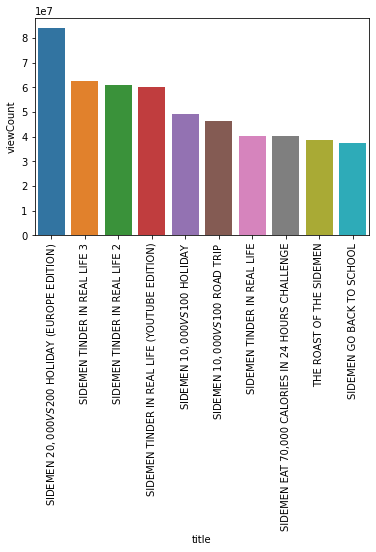

In [11]:
ax = sns.barplot(x="title", y="viewCount", data=video_df.sort_values("viewCount", ascending=False)[0:10])
ax.tick_params(axis="x", rotation=90)
plt.show()

This next plot is a violin plot showing the number of views the videos recieve. On average it would appear the videos on this channel earn between 1 and 2 million views. However there are some outliers that earn 6 to 8 million views.

C:\Users\cotem\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


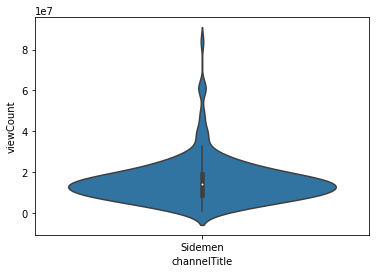

In [12]:
sns.violinplot(video_df["channelTitle"], video_df["viewCount"])
plt.show()

In [13]:
day_df = pd.DataFrame(video_df["dayPublished"].value_counts())
weekdays = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
day_df = day_df.reindex(weekdays)

Finally this plot shows how many videos have been uploaded per day of the week. The vast majority of this channel's videos are uploaded on Sunday which matches the marketing on many of the videos being labeled as Sidemen Sunday.

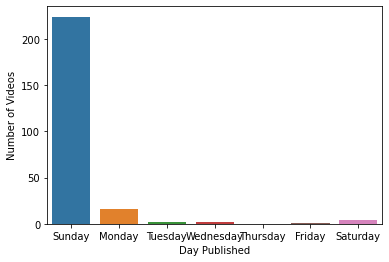

In [14]:
ax = sns.barplot(data=day_df, x=day_df.index, y="dayPublished")
ax.set(xlabel="Day Published", ylabel="Number of Videos")
plt.show()